# Introduction

A store wants to predict store sales per product family per store, with a certain promotion status.

In this competition we need to build a machine learning pipeline to achieve that task.

To analyze data, and to train the machine learning model, we'll be warehousing both the raw data and the processed features, then whenever we need it we'll retrieve it form the warehouse.

In this case we'll use postgres for the warehouse, but it could be done with parquet or any database.

We'll use spark, pandas, numpy and scikit learn for data manipulation

# Quick reference

Holiday events date,type,locale,locale_name,description,transferred
oil date,dcoilwtico
stores store_nbr,city,state,type,cluster
transactions date,store_nbr,transactions
train id,date,store_nbr,family,onpromotion,sales,
test id,date,store_nbr,family,onpromotion

ex id,sales


We'll be given a line with 
id,date,store_nbr,family,onpromotion

We'll need to retrieve any columns we are asked for

# Setup

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 1000)
import pyspark #For accesing dataframe etc with the prefix.
from pyspark.sql import DataFrame as SparkDataFrame, SparkSession
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.pipeline import Pipeline


import sys
#For correctly assigning python variable

import os
#For creating the postgres database programatically

from typing import cast, Dict, LiteralString

from data_preparation_utils import download_kaggle_competition_dataset
from sql_utils import create_db_if_not_exists
from csv_sql_dataset_utils import load_csv_datasets_new_data
import datetime
import csv_datasets

import psycopg
from dotenv import load_dotenv

from sql_utils import execute_queries, execute_query

In [3]:
#Reload all modules imported with %aimport every time before executing the Python code typed. https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
#Careful, it seems like it won't reload the dependancies of reloaded modules, so if the class is not explicitly set here, it wont reload.
%load_ext autoreload
%autoreload explicit

%aimport data_preparation_utils
%aimport configuration_utils
%aimport sql_utils
%aimport csv_sql_dataset_utils


In [4]:
download_kaggle_competition_dataset('../.kaggle/kaggle.json', 'store-sales-time-series-forecasting', '../dataset')#Download dataset if not downloaded

In [5]:
#Fix an error about spark with python, probably necessary because we are not in the same folder as the .venv folder
os.environ['PYSPARK_PYTHON'] = '..\.venv\scripts\python.exe'#sys.executable
#os.environ['PYSPARK_DRIVER_PYTHON'] = '..\.venv\scripts\python.exe' #sys.executable
#Download the postgres jdbc driver and use it with spark
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.postgresql:postgresql:42.7.3 pyspark-shell'


spark_session_builder:SparkSession.Builder = SparkSession.builder # type: ignore <-Ignore a wrong pylance warning, and make type detection work properly
spark:SparkSession = (
    spark_session_builder
    .master('local[3]')
    .appName('TimeSeriesForecastStoreSales Data Engineering')
    .getOrCreate()
)

In [6]:
#keep in mind that if a field doesnt specify not null, its nullable, at least in the database.
#keep in mind that postgres table names are lowercase because otherwise you need to refer to them sorrounded by ""
#keep in mind that while you code write the sql code to create the tables anywhere, its better to at some point add it here, so you can easily reference it.
#Keep in mind the comments will always be applied regardless of if the table existed, allowing you to freely update them.

#Load the database info, its stored in .env files because its simple, allows it to be easily overriden in production, and helps prevent accidentally liking confidential info.
load_dotenv('.\db_settings.env') #Load the database configuration
db_host = os.getenv('db_host')
db_port = os.getenv('db_port')
db_data_engineer_user = os.getenv('db_data_engineer_user')
db_data_engineer_password = os.getenv('db_data_engineer_password')
db_name = os.getenv('db_name')

spark_sql_options = {
    'driver': "org.postgresql.Driver",
    'url': f"jdbc:postgresql://{db_host}:{db_port}/{db_name}",
    'user': db_data_engineer_user,
    'password': db_data_engineer_password,
    'format':'jdbc'
}
# Set database-specific options to be able to execute spark.sql
#spark.conf.set("spark.sql.sources.driver", "org.postgresql.Driver")
#spark.conf.set("spark.sql.sources.url", f"jdbc:postgresql://{db_host}:{db_port}/{db_name}")
#spark.conf.set("spark.sql.sources.user", db_data_engineer_user) # type: ignore
#spark.conf.set("spark.sql.sources.password", db_data_engineer_password) # type: ignore
#spark.conf.set("spark.sql.sources.format", "jdbc")


properties_per_dataset = csv_datasets.properties_per_dataset

In [8]:
table_name = 'test_table'
src = spark.read.format('jdbc').options(**spark_sql_options).option('dbtable', table_name).load()#.select('sales')
src.createOrReplaceTempView(table_name) #Allow it to be visble to spark sql.
src.
spark.sql(f'SELECT * FROM {table_name}')



DataFrame[test_col: int, test_col_2: int, var_to_normalize_normalized: int]

In [11]:
table_2 = 'test_table2'
spark.sparkContext.reg
spark.read.format('jdbc').options(**spark_sql_options).option('query', F'SELECT * FROM {table_name}').load()
#spark.sql('SELECT *')

In [13]:
spark.sql(f"""
ALTER TABLE {table_name} ADD COLUMN metric_new int
""")

AnalysisException: test_table is a temp view. 'ALTER TABLE ... ADD COLUMN' expects a table..; line 2 pos 12

In [14]:
table_2 = 'db_second_view'
spark.read.format('jdbc').options(**spark_sql_options).option('query', F'SELECT * FROM {table_name}').load().createGlobalTempView(table_2)
#spark.sql('SELECT *')

In [16]:
spark.sql(f"""
ALTER TABLE {table_2} ADD COLUMNS metric_new int
""")

AnalysisException: db_second_view is a temp view. 'ALTER TABLE ... ADD COLUMNS' expects a table..; line 2 pos 12

In [12]:
table_2 = 'test_table2'
spark.read.format('jdbc').options(**spark_sql_options).option('query', '''SELECT CREATE TABLE IF NOT EXISTS public.test_table2
(
    test_col integer,
    test_col_2 integer
)''').load().createOrReplaceTempView('db_second_view')

Py4JJavaError: An error occurred while calling o105.load.
: org.postgresql.util.PSQLException: ERROR: syntax error at or near "CREATE"
  Position: 16
	at org.postgresql.core.v3.QueryExecutorImpl.receiveErrorResponse(QueryExecutorImpl.java:2725)
	at org.postgresql.core.v3.QueryExecutorImpl.processResults(QueryExecutorImpl.java:2412)
	at org.postgresql.core.v3.QueryExecutorImpl.execute(QueryExecutorImpl.java:371)
	at org.postgresql.jdbc.PgStatement.executeInternal(PgStatement.java:502)
	at org.postgresql.jdbc.PgStatement.execute(PgStatement.java:419)
	at org.postgresql.jdbc.PgPreparedStatement.executeWithFlags(PgPreparedStatement.java:194)
	at org.postgresql.jdbc.PgPreparedStatement.executeQuery(PgPreparedStatement.java:137)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD$.getQueryOutputSchema(JDBCRDD.scala:68)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD$.resolveTable(JDBCRDD.scala:58)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRelation$.getSchema(JDBCRelation.scala:241)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:37)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:346)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:172)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Unknown Source)


In [7]:


spark.sql('''CREATE TABLE IF NOT EXISTS public.test_table2
(
    test_col integer,
    test_col_2 integer
)''')


AnalysisException: [NOT_SUPPORTED_COMMAND_WITHOUT_HIVE_SUPPORT] CREATE Hive TABLE (AS SELECT) is not supported, if you want to enable it, please set "spark.sql.catalogImplementation" to "hive".;
'CreateTable `spark_catalog`.`public`.`test_table2`, org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe, Ignore


In [12]:
spark.sql('''ALTER TABLE test_table DROP COLUMN IF EXISTS test_col;
''')

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `test_table` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 1 pos 12;
'DropColumns [unresolvedfieldname(test_col)], true
+- 'UnresolvedTable [test_table], ALTER TABLE ... DROP COLUMNS


In [ ]:
load_csv_datasets_new_data(spark, spark_sql_options, properties_per_dataset)

In [1]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

dataset = spark.createDataFrame(
    [(1, 0,  1), (2, 10, 0), (3,5,1)],
    ["id", "hour", "clicked"])

dataset.show()

assembler = VectorAssembler(
    inputCols=["hour"],
    outputCol="hour_vec")

output = assembler.transform(dataset)

print("Transformed hour into vectors type ")

output.show()

mm_scaler = MinMaxScaler(inputCol='hour_vec', outputCol='hour_norm')
output_norm = mm_scaler.fit(output).transform(output)
output_norm.show()


NameError: name 'spark' is not defined

In [16]:
# To test using sql alter table.
from pyspark.sql.dataframe import DataFrame


def create_normalized_variable(var_to_normalize, table_name):
    from pyspark.sql.functions import expr
    """C"""
    src = spark.read.format('jdbc').options(**spark_sql_options).option('dbtable', table_name).load()#.select('sales')
    src.createOrReplaceTempView(table_name)
    spark.sql(f'ALTER TABLE {table_name} ADD COLUMN new_col INTEGER')
    #df: DataFrame = src.withColumn(var_to_normalize+'_normalized', expr("test_col*2"))
    #df.write.format('jdbc').mode('overwrite').options(**spark_sql_options).option('dbtable', table_name).save() # Esto funciona prero probablemente es una mala idea. Lo mejor debe ser un storagetransformer.
    

create_normalized_variable('var_to_normalize', 'test_table')
    #spark.write.format('jdbc').sql(f"ALTER TABLE {table_name} ADD COLUMN IF NOT EXISTS {normalized_col_name} INTEGER;")

In [ ]:
from pyspark.sql.dataframe import DataFrame


def create_normalized_variable(var_to_normalize, table_name):
    from pyspark.sql.functions import expr
    """C"""
    src = spark.read.format('jdbc').options(**spark_sql_options).option('dbtable', table_name).load()#.select('sales')
    
    df: DataFrame = src.withColumn(var_to_normalize+'_normalized', expr("test_col*2"))
    df.write.format('jdbc').mode('overwrite').options(**spark_sql_options).option('dbtable', table_name).save() # Esto funciona prero probablemente es una mala idea. Lo mejor debe ser un storagetransformer.
    

create_normalized_variable('var_to_normalize', 'test_table')

In [20]:
from pyspark.sql.dataframe import DataFrame

def create_normalized_variable(var_to_normalize, table_name):
    from pyspark.sql.functions import expr
    """C"""
    src = spark.read.format('jdbc').options(**spark_sql_options).option('dbtable', table_name).load().select('test_col')
    mm_scaler = MinMaxScaler(inputCol='test_col', outputCol='test_col_norm')
    mm_scaler.fit(src).transform(src)
    
    return src
    #df: DataFrame = src.withColumn(var_to_normalize+'_normalized', expr("test_col*2"))
    #df.write.format('jdbc').mode('overwrite').options(**spark_sql_options).option('dbtable', table_name).save() # Esto funciona prero probablemente es una mala idea. Lo mejor debe ser un storagetransformer.

create_normalized_variable('var_to_normalize', 'test_table').show(5)

#create_normalized_variable('var_to_normalize', 'test_table')
    #spark.write.format('jdbc').sql(f"ALTER TABLE {table_name} ADD COLUMN IF NOT EXISTS {normalized_col_name} INTEGER;")

IllegalArgumentException: requirement failed: Column test_col must be of type class org.apache.spark.ml.linalg.VectorUDT:struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually class org.apache.spark.sql.types.IntegerType$:int.

In [30]:
def create_normalized_sales_first_approach():
    from pyspark.ml.feature import VectorAssembler, Imputer
    src = spark.read.format('jdbc').options(**spark_sql_options).option('dbtable', 'oil_prices').load()#.select('sales')
    
    imputer = Imputer(inputCols=["dcoilwtico"], outputCols=["oil_prices_imputted_as_-1"], missingValue=-1)
    assembler = VectorAssembler(inputCols=["oil_prices_imputted_as_-1"], outputCol="oil_prices_vec")
     #strategy='constant',
    mm_scaler = MinMaxScaler(inputCol='oil_prices_vec', outputCol='oil_prices_norm')#.fit(src)#Aca puedo pasar params para overidear tmabien.
    pipeline = Pipeline(stages=[imputer, assembler,  mm_scaler]).fit(src)
    result = pipeline.transform(src) #Add the sales_vec and sales_normalized column to the dataframe.
    #result = mm_scaler.transform(src)
    #result.drop('oil_prices_vec').write.format('jdbc').mode('overwrite').options(**spark_sql_options).option('dbtable', 'oil_prices').save()# #Could be appended instead. 
    return result
    
normalized_sales = create_normalized_sales_first_approach()
#normalized_sales.show(10)

Py4JJavaError: An error occurred while calling o1001.load.
: org.postgresql.util.PSQLException: ERROR: relation "oil_prices" does not exist
  Position: 15
	at org.postgresql.core.v3.QueryExecutorImpl.receiveErrorResponse(QueryExecutorImpl.java:2725)
	at org.postgresql.core.v3.QueryExecutorImpl.processResults(QueryExecutorImpl.java:2412)
	at org.postgresql.core.v3.QueryExecutorImpl.execute(QueryExecutorImpl.java:371)
	at org.postgresql.jdbc.PgStatement.executeInternal(PgStatement.java:502)
	at org.postgresql.jdbc.PgStatement.execute(PgStatement.java:419)
	at org.postgresql.jdbc.PgPreparedStatement.executeWithFlags(PgPreparedStatement.java:194)
	at org.postgresql.jdbc.PgPreparedStatement.executeQuery(PgPreparedStatement.java:137)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD$.getQueryOutputSchema(JDBCRDD.scala:68)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD$.resolveTable(JDBCRDD.scala:58)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRelation$.getSchema(JDBCRelation.scala:241)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:37)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:346)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:172)
	at jdk.internal.reflect.GeneratedMethodAccessor82.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Unknown Source)


: 

In [ ]:
spark.createDataFrame([], )

In [ ]:
def creat_engineering_pipeline():
    data_engineering_pipeline =  Pipeline([])

In [ ]:
data_engineering_pipeline = Pipeline([])

In [10]:



src.write()


Full filter: (store_nbr > '54')
Full filter: (id > '1899')
Full filter: (date > '2013-01-04') AND (store_nbr > '7')
Full filter: (date > '2014-04-18') AND (type > 'Holiday') AND (locale > 'National') AND (locale_name > 'Ecuador') AND (description > 'Viernes Santo') AND (transferred > 'False')
Full filter: (date > '2013-10-07')


# Legacy

In [ ]:
def get_current_sales_data() -> pyspark.sql.DataFrame:
    #Verificado, funciona perfecto
    current_entries:pyspark.sql.DataFrame = spark.read.format('jdbc').options(query='SELECT * FROM sales_fact_data').options(**spark_sql_options).load()
    return current_entries

current_sales_data = get_current_sales_data()

In [ ]:

new_entries:pyspark.sql.DataFrame = (
    spark.read.csv(
    './dataset/train.csv',
    header=True, #Let spark know to ignore header
    schema=last_sales_data.schema
    ).filter(f'{primary_key_string} > {last_sales_data.select(primary_key_string).first() or -1}')
)
new_entries.show(10)

+---+----------+---------+-------------------+-----+-----------+
| id|      date|store_nbr|             family|sales|onpromotion|
+---+----------+---------+-------------------+-----+-----------+
| 11|2013-01-01|        1|       FROZEN FOODS|  0.0|          0|
| 12|2013-01-01|        1|          GROCERY I|  0.0|          0|
| 13|2013-01-01|        1|         GROCERY II|  0.0|          0|
| 14|2013-01-01|        1|           HARDWARE|  0.0|          0|
| 15|2013-01-01|        1| HOME AND KITCHEN I|  0.0|          0|
| 16|2013-01-01|        1|HOME AND KITCHEN II|  0.0|          0|
| 17|2013-01-01|        1|    HOME APPLIANCES|  0.0|          0|
| 18|2013-01-01|        1|          HOME CARE|  0.0|          0|
| 19|2013-01-01|        1|         LADIESWEAR|  0.0|          0|
| 20|2013-01-01|        1|    LAWN AND GARDEN|  0.0|          0|
+---+----------+---------+-------------------+-----+-----------+
only showing top 10 rows



In [ ]:
sales_fact_data = get_new_sales_rows()
sales_fact_data.schema

TypeError: get_sales_fact_data() missing 1 required positional argument: 'last_entry'

In [ ]:
sales_fact_data.show(10)

NameError: name 'sales_fact_data' is not defined

In [ ]:
spark.write('jdbc').options()

In [ ]:
#Errors likely by desc without order by
#last_sales_data = (
#    spark.read.format('jdbc')
#    .options(**spark_sql_options)
#    .option('query', 'SELECT * FROM sales_data DESC LIMIT 1')
#    .load()
#)
#.option("partitionColumn", "date")
#.option("lowerBound", "2020-01-01")
#.option("upperBound", "2020-12-31")
#.option("numPartitions", 12)
#.schema(customSchema)
#.option("samplingRatio", 0.5)



In [ ]:
def load_new_transaction_data():
    transactions_data:pyspark.sql.DataFrame = get_transactions_data()
    (transactions_data.write
    .mode('append')
    .format('jdbc')
    .options(**spark_sql_options)
    .option('dbtable', 'transactions_data')
    .save()
    )

def load_new_stores_data():
    stores_data:pyspark.sql.DataFrame = get_stores_data()
    (stores_data.write
    .format('jdbc')
    .options(**spark_sql_options)
    .option('dbtable', 'stores_data')
    .save()
    )

def load_new_holidays_events_data():
    holidays_events_data:pyspark.sql.DataFrame = get_holidays_events_data()
    (holidays_events_data.write
    .format('jdbc')
    .options(**spark_sql_options)
    .option('dbtable', 'holidays_events')
    .save()
    )

def load_new_oil_data():
    oil_data:pyspark.sql.DataFrame = get_oil_data()
    (oil_data.write
    .mode('append')
    .format('jdbc')
    .options(**spark_sql_options)
    .option('dbtable', 'oil_data')
    .save()
    )

def load_new_sales_fact_data():
    sales_fact_data:pyspark.sql.DataFrame = get_new_sales_rows()
    (sales_fact_data.write
        .format('jdbc')
        .options(**spark_sql_options)
        .option('dbtable', 'sales_fact_data')
        .save()
    )

#def get_and_store_raw_data():


In [ ]:
data = spark.read.csv(
            './dataset/holidays_events.csv',
            header=True,
            schema=holidays_data.schema
)
data.schema

StructType([StructField('date', DateType(), True), StructField('type', StringType(), True), StructField('locale', StringType(), True), StructField('locale_name', StringType(), True), StructField('description', StringType(), True), StructField('transferred', BooleanType(), True)])

In [ ]:
load_new_oil_data()

In [ ]:




    #.option("partitionColumn", "date")
    #.option("lowerBound", "2020-01-01")
    #.option("upperBound", "2020-12-31")
    #.option("numPartitions", 12)
    #.schema(customSchema)
    #.option("samplingRatio", 0.5)
last_sale_df.show() 

+----------+---------+------------+
|      date|store_nbr|transactions|
+----------+---------+------------+
|2013-01-01|       25|         770|
|2013-01-02|        1|        2111|
|2013-01-02|        2|        2358|
|2013-01-02|        3|        3487|
|2013-01-02|        4|        1922|
+----------+---------+------------+



In [ ]:
from sqlalchemy import create_engine
#Sql alchemy uses psycopg under the hood and pyscopg is apparently faster than postgres odbc driver, but im not sure vs jdbc
#https://docs.sqlalchemy.org/en/20/dialects/postgresql.html#module-sqlalchemy.dialects.postgresql.psycopg
sql_alchemy_conn_string = f"postgresql+psycopg://{db_info['user']}:{db_info['password']}@{db_host}:5432/{db_info['dbname']}?client_encoding=utf8"
engine = create_engine(sql_alchemy_conn_string)

column_names_dict {'dcoilwtico':'date'}
def create_sql_statement(column_names)

pipeline 1 = Pipeline(
                whateverfunction_trnasformer,
                whatever_other_transformer
            )
            

# Prepare the dataset for the pipeline

In [ ]:
#dataset = data_prep.get_train_dataset(length='all')
dataset = data_prep.get_train_dataset(length=5000)
y = dataset.attrs['sales']

cat_cols_to_ohe = ['store_nbr', 'store_cluster', 'product_family', 'store_city','store_state', 'store_type', 'day_type', 'special_day_locale_type', 'special_day_locale',
                    'special_day_reason',  'special_day_transferred'#,'special_day_reason_subtype', 
                    ]
numerical_features_to_min_max_scale = ['oil_price', 'all_products_transactions']

# Pipeline 0

In [ ]:
print('evaluating xgb base pipeline')
xgb_pipeline_0 = Pipeline([
    ('rename_columns', FunctionTransformer(data_prep.rename_raw_dfs_cols)),
    ('merge_datasets', FunctionTransformer(data_prep.merge_data_sources, kw_args={'merge_oil':True, 'merge_stores':True, 'merge_special_days':True, 'merge_transactions':True})),
    
    ("column_selector", ColumnTransformer([
        ('use_columns', 'passthrough', ['store_nbr']) #passthrough is a keyword making a transformer that yields the columns
    ], remainder="drop", verbose_feature_names_out=False).set_output(transform='pandas')), #verbose_feature_names_out False = dont prefix with 'use_columns'
    ('model', XGBRegressor())
])


display(xgb_pipeline_0[:len(xgb_pipeline_0)-1].fit_transform(dataset,y).head(1))
from sklearn.model_selection import KFold
kf_generator = KFold(5, shuffle = False)
cross_validation = cross_validate(xgb_pipeline_0, dataset, y, return_estimator=True, return_train_score=True, cv=kf_generator)
display(f'cross_validation.train_scores : {cross_validation["train_score"]} -> avg = {np.average(cross_validation["train_score"])}')
display(f'cross_validation.test_scores : {cross_validation["test_score"]} -> avg = {np.average(cross_validation["test_score"])}')
cross_validation_estimators = cross_validation['estimator']

evaluating xgb base pipeline


,store_nbr
0,1


'cross_validation.train_scores : [0.0375509  0.06907424 0.03940429 0.03426464 0.02875673] -> avg = 0.04181015861446944'

'cross_validation.test_scores : [-3.58623449e+01 -8.83699106e-01  2.74258139e-03 -2.77459368e-02\n  5.12698485e-02] -> avg = -7.343955505231364'

In [ ]:
#for fold_number, (train_index, test_index) in enumerate(kf_generator.split(dataset,y)):
    #x_train, x_test = dataset[train_index], dataset[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    #Or just check if an x is in the index for coloring : https://stackoverflow.com/questions/67956643/how-to-get-indices-of-instances-during-cross-validation
    #sns.lineplot()


# Pipeline 2

In [ ]:
from IPython.display import display
import warnings
import sys
original_stdout = sys.stdout

def raise_error_about_unhandled_columns(x):
    raise ValueError(f'Unhandled columns: {x.columns.to_list()} . Handle them even if its just using "passhtrough" as transformer to use them as they are.)')



In [ ]:
def ColumnTransformerAttrsCompatible(ColumnTransformer):
    def _hstack(self, Xs):
        """Stacks Xs horizontally.

        This allows subclasses to control the stacking behavior, while reusing
        everything else from ColumnTransformer.

        Parameters
        ----------
        Xs : list of {array-like, sparse matrix, dataframe}
        """
        return Xs
    

In [ ]:
def _hstack(self, Xs):
        """Stacks Xs horizontally.

        This allows subclasses to control the stacking behavior, while reusing
        everything else from ColumnTransformer.

        Parameters
        ----------
        Xs : list of {array-like, sparse matrix, dataframe}
        """
        from sklearn.utils.validation import (
            _check_feature_names_in,
            _get_feature_names,
            _is_pandas_df,
            _num_samples,
            check_array,
            check_is_fitted,
        )
        from scipy import sparse
        from sklearn.compose._column_transformer import _get_container_adapter

        if self.sparse_output_:
            try:
                # since all columns should be numeric before stacking them
                # in a sparse matrix, `check_array` is used for the
                # dtype conversion if necessary.
                converted_Xs = [
                    check_array(X, accept_sparse=True, force_all_finite=False)
                    for X in Xs
                ]
            except ValueError as e:
                raise ValueError(
                    "For a sparse output, all columns should "
                    "be a numeric or convertible to a numeric."
                ) from e

            return sparse.hstack(converted_Xs).tocsr()
        else:
            print(type(Xs))
            print(Xs[0])
            print([X.attrs.keys() for X in Xs])
            Xs = [f.toarray() if sparse.issparse(f) else f for f in Xs]
            adapter = _get_container_adapter("transform", self)
            if adapter and all(adapter.is_supported_container(X) for X in Xs):
                output = adapter.hstack(Xs)

                output_samples = output.shape[0]
                if any(_num_samples(X) != output_samples for X in Xs):
                    raise ValueError(
                        "Concatenating DataFrames from the transformer's output lead to"
                        " an inconsistent number of samples. The output may have Pandas"
                        " Indexes that do not match."
                    )

                # If all transformers define `get_feature_names_out`, then transform
                # will adjust the column names to be consistent with
                # verbose_feature_names_out. Here we prefix the feature names if
                # verbose_feature_names_out=True.

                if not self.verbose_feature_names_out:
                    print('output is not self verbose features')
                    print(Xs.attrs.keys())
                    return output

                transformer_names = [
                    t[0]
                    for t in self._iter(
                        fitted=True,
                        column_as_labels=False,
                        skip_drop=True,
                        skip_empty_columns=True,
                    )
                ]
                # Selection of columns might be empty.
                # Hence feature names are filtered for non-emptiness.
                feature_names_outs = [X.columns for X in Xs if X.shape[1] != 0]
                names_out = self._add_prefix_for_feature_names_out(
                    list(zip(transformer_names, feature_names_outs))
                )
                return adapter.rename_columns(output, names_out)

            return np.hstack(Xs)

In [ ]:
ColumnTransformer._hstack = _hstack

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
window_size = 2
columns_to_standardize = []
columns_to_ohe = []

xgb_pipeline_1 = Pipeline([
    ('rename_columns', FunctionTransformer(data_prep.rename_raw_dfs_cols)),
    ('merge_datasets', FunctionTransformer(data_prep.merge_data_sources, kw_args={'merge_oil':True, 'merge_stores':True, 'merge_special_days':True, 'merge_transactions':True})),
    #('reorder_features', FunctionTransformer(reorder_features_dataset)), #The order of columns cant change in the middle of the pipeline if runnign cross validate.
    ('fill_missing_oil_values', FunctionTransformer(data_prep.fill_missing_oil_values)),
    ('fill_missing_transactions', FunctionTransformer(data_prep.fill_missing_transactions)),
    ('refine_special_day_reason', FunctionTransformer(data_prep.refine_special_day_reason)), #Isnt placed where the column came from.
    ('replace_date_with_date_related_columns', FunctionTransformer(data_prep.replace_date_with_date_related_columns)),#Careful, moving calling this earlier could be problematic since it eliminates date column.
    #('display_current_cols_example', FunctionTransformer(lambda x: display(x.head(1)))), #Returns none xd #errors after displaying 5 times: ValueError: Expected 2D array, got scalar array instead: #array=None. #Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
    ('prepare_features', ColumnTransformer([
        ('standardize_numerical_features', MinMaxScaler(), ['oil_price', 'all_products_transactions']),
        ('prepare_categorical_columns', data_prep.CustomOneHotEncoder(cat_cols_to_ohe), cat_cols_to_ohe),
        ('use_features_as_are', 'passthrough', ['store_nbr', 'products_of_family_on_promotion', 'store_cluster', 'all_transactions_filled', 'special_day_offset', 'days_since_start', 'day_of_year', 'day_of_month', 'day_of_week', 'is_15th', 'is_last_day_of_month']),
    ], remainder=FunctionTransformer(raise_error_about_unhandled_columns), sparse_threshold=0, n_jobs=3, verbose_feature_names_out=False, verbose=True).set_output(transform='pandas')),
    #('window_dataset', FunctionTransformer(data_prep.rolling_window_dataset, kw_args={'window_size': window_size})),
    ("column_selector", ColumnTransformer([
        ('use_columns', 'passthrough', ['store_nbr']) #passthrough is a keyword making a transformer that yields the columns
    ], remainder="drop", verbose_feature_names_out=False).set_output(transform='pandas')), #verbose_feature_names_out False = dont prefix with 'use_columns'
    ('model', XGBRegressor())
],)

#kf_generator = KFold(5, shuffle = False)
#cross_validation = cross_validate(xgb_pipeline_1, dataset, y, return_estimator=True, return_train_score=True, cv=kf_generator)
#display(f'cross_validation.train_scores : {cross_validation["train_score"]} -> avg = {np.average(cross_validation["train_score"])}')
#display(f'cross_validation.test_scores : {cross_validation["test_score"]} -> avg = {np.average(cross_validation["test_score"])}')

#la solucion mas facil por ahi es hacer que conserve bien los attrs el column selector, si es que estan bien conservados en el resto. Parece serlo. #Digamos, no le llamaria facil
#Creo que esto en linea 1082 de column_transformer es el momento en el que se devuelve el array return adapter.rename_columns(output, names_out) def _hstack(self, Xs):


In [ ]:
xgb_pipeline_1[:7].fit_transform(dataset).attrs.keys()
Pareceria que tal vez es el standard scaler el problema?

<class 'list'>
      oil_price  all_products_transactions
0           1.0                   0.000000
1           1.0                   0.000000
2           1.0                   0.000000
3           1.0                   0.000000
4           1.0                   0.000000
...         ...                        ...
4995        0.0                   0.348342
4996        0.0                   0.348342
4997        0.0                   0.348342
4998        0.0                   0.348342
4999        0.0                   0.348342

[5000 rows x 2 columns]
[dict_keys([]), dict_keys(['stores_df', 'oil_df', 'transactions_df', 'special_days_df', 'sales']), dict_keys(['stores_df', 'oil_df', 'transactions_df', 'special_days_df', 'sales'])]
output is not self verbose features


AttributeError: 'list' object has no attribute 'attrs'

NameError: name 'xgb_pipeline_0' is not defined

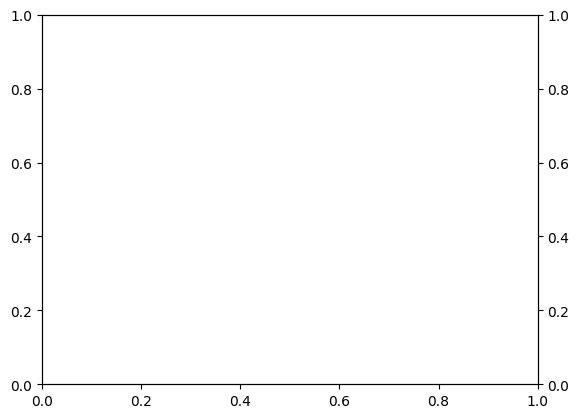

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.twinx()

predictions = cross_val_predict(xgb_pipeline_0, dataset, y)
ax_1 = sns.barplot(x=dataset.store_nbr, y=y)
ax_2 = sns.barplot(x=dataset.store_nbr, y=predictions)


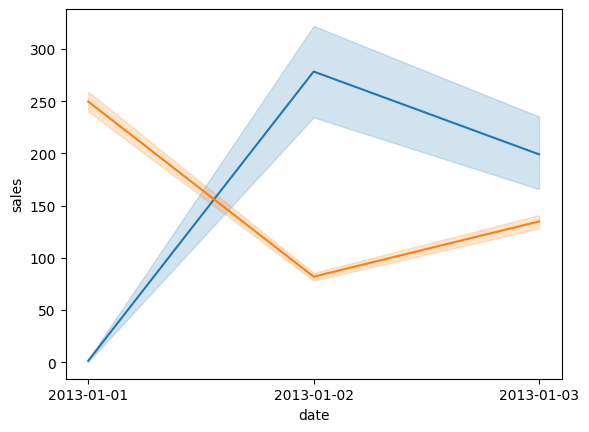

In [ ]:
ax_1 = sns.lineplot(x=dataset.date, y=y)
ax_2 = sns.lineplot(x=dataset.date, y=predictions)

In [ ]:
xgb_pipeline_0, dataset, y

In [ ]:
print('evaluating xgb pipeline with oil:')
xgb_base_pipeline_1 = Pipeline([
    ('rename_columns', FunctionTransformer(data_prep.rename_raw_dfs_cols)),
    ('merge_datasets', FunctionTransformer(data_prep.merge_data_sources, kw_args={'merge_oil':True, 'merge_stores':True, 'merge_special_days':True, 'merge_transactions':True})),
    ("column_selector", ColumnTransformer([
        ('use_columns', 'passthrough', ['store_nbr']) #passthrough is a keyword making a transformer that yields the columns
    ], remainder="drop", verbose_feature_names_out=False).set_output(transform='pandas')), #verbose_feature_names_out False = dont prefix with 'use_columns'
    ('model', XGBRegressor())
])

display(xgb_base_pipeline_1[:len(xgb_base_pipeline_1)-1].fit_transform(dataset,y).head(1))
cross_validate(xgb_base_pipeline_1, dataset, y)


evaluating xgb pipeline with oil:


,store_nbr
0,1


{'fit_time': array([0.38499403, 0.39552164, 0.19399714, 0.20199704, 0.18800306]),
 'score_time': array([0.16099977, 0.08051777, 0.08000255, 0.09209347, 0.08499718]),
 'test_score': array([-3.58623449e+01, -8.83699106e-01,  2.74258139e-03, -2.77459368e-02,
         5.12698485e-02])}

In [ ]:
entire_dataframes = data_prep.get_train_dataset(50000)

pipeline = Pipeline([
    ('fill_missing_oil_values', FunctionTransformer(fill_missing_oil_values)), #Could be achievable with sklearn most likely
    ('fill_missing_transactions', FunctionTransformer(fill_missing_transactions)),
    ('refine_special_day_reason', FunctionTransformer(refine_special_day_reason)), #Isnt placed where the column came from.
    ('replace_date_with_date_related_columns', FunctionTransformer(replace_date_with_date_related_columns)), #Careful, moving calling this earlier could be problematic since it eliminates date column.
    #('reorder_features', FunctionTransformer(reorder_features_dataset)), #The order of columns cant change in the middle of the pipeline if runnign cross validate.
    ('prepare_features', ColumnTransformer([
        ('standardize_numerical_features', MinMaxScaler(), numerical_features_to_min_max_scale), 
        ('prepare_categorical_columns', CustomOneHotEncoder(cat_cols_to_ohe), cat_cols_to_ohe),
    ], remainder='passthrough', sparse_threshold=0, n_jobs=3, verbose_feature_names_out=False).set_output(transform='pandas')),
    ('window_dataset', FunctionTransformer(rolling_window_dataset, kw_args={'window_size': window_size})),
    ('drop_target', FunctionTransformer(drop_target)),
    ('model', XGBRegressor()) #instead of linear regressor
], verbose=verbose)



window_size = 5
pipeline = data_prep.create_pipeline(window_size, verbose=True) 

cross_val_results = cross_validate(pipeline, all_features, all_features['sales'], cv=TimeSeriesSplit(n_splits=5),error_score='raise',
                                   return_indices=False, return_estimator=False, return_train_score=True)
                                   

display(cross_val_results['train_score'])
display(cross_val_results['test_score'])

display(np.average(cross_val_results['train_score']))
display(np.average(cross_val_results['test_score']))

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   8.1s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.5s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   1.9s
[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.1s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   1.5s

array([0.5559754 , 0.57023668, 0.59899458, 0.61403497, 0.61446357])

array([-6.38263450e+15, -1.73188389e+14, -9.57927080e+15,  6.18300756e-01,
        6.78957465e-01])

0.5907410400258568

-3227018737202953.5

c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.1s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['day_of_year'] = features_df['date'].dt.dayofyear
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['day_of_month'] = features_df['date'].dt.day
c:\Users\uriel.salvio\Documents\Python Projects\ML exam

[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.1s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   5.9s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.4s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   1.8s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.8s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.6s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   2.6s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.7s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   1.2s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   4.3s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['special_day_reason'] = features_df['special_day_reason'].apply(process_special_day_reason_value)
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['date'] = pd.to_datetime(features_df['date'],format=

[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.3s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.2s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   1.3s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   2.1s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   4.6s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   1.1s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   2.2s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.1s
[Pipeline] ............. (step 8 of 8) Processing model, total=   5.9s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

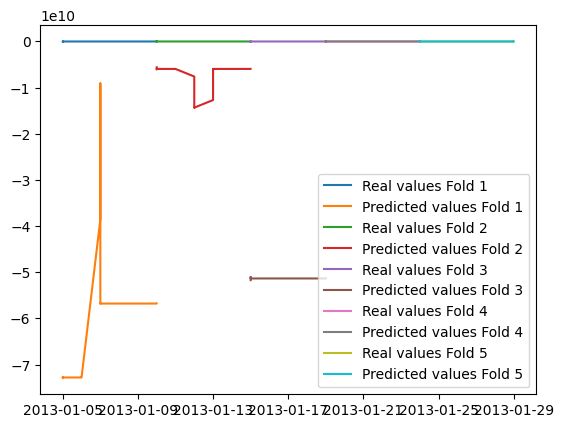

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Convert the date column to datetime
all_features['date'] = pd.to_datetime(all_features['date'], format='%Y-%M-%d')

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

fig, ax = plt.subplots()

# For each split train the model and plot the real and predicted values
for i, (train_index, test_index) in enumerate(tscv.split(all_features)):
    train, test = all_features.iloc[train_index], all_features.iloc[test_index]
    
    # Fit the pipeline on the training data
    pipeline.fit(train, train['sales'])
    
    # Predict the sales on the test data
    predictions = pipeline.predict(test)
    
    # Plot the real and predicted values
    ax.plot(test['date'], test['sales'], label=f'Real values Fold {i+1}')
    ax.plot(test['date'], predictions, label=f'Predicted values Fold {i+1}')

plt.legend()
plt.show()


In [ ]:
entire_dataframes = data_prep.get_feature_dfs()

#The dataframe for training, and crossvalidation
cross_val_dataframes:TimeSeriesForecastDataframes = TimeSeriesForecastDataframes(entire_dataframes.base_xy_df[:500000],
                                                                                entire_dataframes.stores_df,
                                                                                entire_dataframes.oil_df,
                                                                                entire_dataframes.transactions_df,
                                                                                entire_dataframes.special_days_df)

merging_pipeline = data_prep.create_merging_pipeline()
all_features:pd.DataFrame = merging_pipeline.fit_transform(cross_val_dataframes)

In [ ]:
all_features.columns

Index(['date', 'store_nbr', 'product_family', 'sales',
       'products_of_family_on_promotion', 'oil_price', 'store_city',
       'store_state', 'store_type', 'store_cluster', 'day_type',
       'special_day_locale_type', 'special_day_locale', 'special_day_reason',
       'special_day_transferred', 'all_products_transactions',
       'days_since_start'],
      dtype='object')

c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   4.1s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.8s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   1.6s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.5s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   0.7s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   2.7s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.7s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   1.3s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   3.3s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.8s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   1.5s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   4.3s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

[Pipeline]  (step 1 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 2 of 8) Processing fill_missing_transactions, total=   0.0s
[Pipeline]  (step 3 of 8) Processing refine_special_day_reason, total=   0.0s
[Pipeline]  (step 4 of 8) Processing replace_date_with_date_related_columns, total=   0.0s
[Pipeline] .. (step 5 of 8) Processing prepare_features, total=   0.9s
[Pipeline] .... (step 6 of 8) Processing window_dataset, total=   2.0s
[Pipeline] ....... (step 7 of 8) Processing drop_target, total=   0.0s
[Pipeline] ............. (step 8 of 8) Processing model, total=   5.3s


c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].ffill()#.fillna(method='ffill')
c:\Users\uriel.salvio\Documents\Python Projects\ML examples\TimeSeriesForecastStoreSales\data_preparation_attempt3.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df['oil_price'] = features_df['oil_price'].bfill() #Make sure that if the first e

Train scores: [431.44498122126237, 467.51802832779936, 437.4367896894062, 405.89378902727935, 409.419865614116]
Test scores: [61733140562.632095, 8471069634.103374, 51352531331.05551, 421.95840564624507, 356.0964644421812]


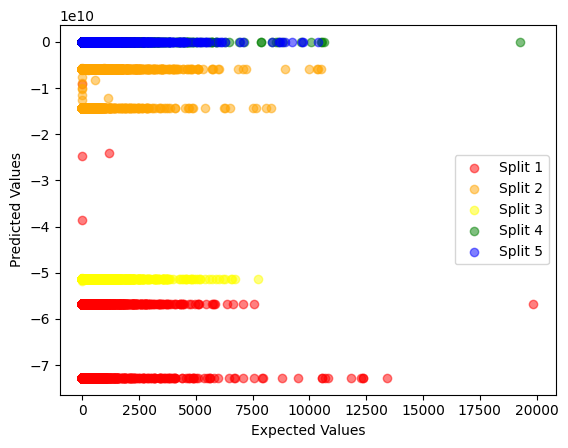

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store train and test scores
train_scores = []
test_scores = []

# Initialize a list of colors for plotting
colors = ['red', 'orange', 'yellow', 'green', 'blue']

# Loop over each split
for i, (train_index, test_index) in enumerate(tscv.split(all_features)):
    # Split the data
    X_train, X_test = all_features.iloc[train_index], all_features.iloc[test_index]
    y_train, y_test = all_features['sales'].iloc[train_index], all_features['sales'].iloc[test_index]

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Get predictions for both the training and test data
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate and store the train and test scores
    train_scores.append(mean_squared_error(y_train, y_train_pred, squared=False))
    test_scores.append(mean_squared_error(y_test, y_test_pred, squared=False))

    # Plot the predicted vs expected values for the test data
    plt.scatter(y_test, y_test_pred, color=colors[i], alpha=0.5, label=f'Split {i+1}')

# Print the train and test scores
print('Train scores:', train_scores)
print('Test scores:', test_scores)

# Add labels and legend to the plot
plt.xlabel('Expected Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.show()


In [ ]:
cross_val_predict_results = cross_val_predict(pipeline, all_features, all_features['sales'], cv=TimeSeriesSplit(n_splits=5))

ValueError: cross_val_predict only works for partitions

In [ ]:
import sklearn
with sklearn.config_context(skip_parameter_validation=True):

    cross_val_results = cross_val_score(pipeline, cross_val_dataframes, cross_val_y_truth, cv=TimeSeriesSplit(n_splits=5))
    pipeline.fit(cross_val_dataframes, cross_val_y_truth)

    #The dataframe for outer validation
    outer_val_dataframes:TimeSeriesForecastDataframes = TimeSeriesForecastDataframes(entire_dataframes.base_xy_df[50000:100000],
                                                                                    entire_dataframes.stores_df,
                                                                                    entire_dataframes.oil_df,
                                                                                    entire_dataframes.transactions_df,
                                                                                    entire_dataframes.special_days_df)
    outer_val_y_truth:pd.Series = outer_val_dataframes.base_xy_df['sales']
    outer_val_score = pipeline.score(outer_val_dataframes, outer_val_y_truth)
    outer_val_predictions = pipeline.predict(outer_val_dataframes)
    outer_val_score_from_predictions = r2_score(outer_val_y_truth, outer_val_predictions)


    pipeline.score_samples()

    submission_dfs = TimeSeriesForecastDataframes(additionalDataframes.elements_to_predict_x_base_df,
                                                    entire_dataframes.stores_df,
                                                    entire_dataframes.oil_df,
                                                    entire_dataframes.transactions_df,
                                                    entire_dataframes.special_days_df)

    predictions = pipeline.predict(submission_dfs)

NameError: name 'cross_val_y_truth' is not defined

In [ ]:
# Outer validation predictions
plt.figure(figsize=(7, 5))
plt.plot(outer_val_y_truth.index, outer_val_y_truth, label='Truth')
plt.plot(outer_val_y_truth.index, outer_val_predictions, label='Predictions')
plt.title('Outer Validation Predictions')
plt.legend()
plt.show()
print(f'Outer validation score: {outer_val_score}')

# Future data predictions
plt.figure(figsize=(7, 5))
plt.plot(submission_dfs.base_xy_df.index, predictions, label='Predictions')
plt.title('Future Data Predictions')
plt.legend()
plt.show()

In [ ]:
#This line and the next one could be inside objective trial if we wanted to tune those aswell.
#Create a preprocessing pipeline (without fitting it to anything)
pipeline = data_prep.create_pipeline(stores_df, oil_df, transactions_df, special_days_df, window_size=2, verbose=True) #El de date tardo mucho.



#A df containing both the current and the target values, considering this is time dataset. The question is how to split it.
#This dataframe contains the current features incluiding the store sales and the features with a certain lag named lag_N
processed_train_df:pd.DataFrame = pipeline.fit_transform(train_df[:100000], train_y_truth[:100000])

features_df = processed_train_df.drop('all_products_transactions')
target_df = processed_train_df['all_products_transactions']

scores = cross_val_score(pipeline, train_df, train_y_truth, cv=5)


#It seems that pipelines have fit, transform and predict method though so it might be unnecesary to separate them.


#import tensorflow as tf
#import keras
#from tqdm import tqdm

processed_elements_to_predict = pipeline.transform(elements_to_predict_df)



[Pipeline] .... (step 1 of 8) Processing rename_columns, total=   0.0s


[Pipeline] .. (step 2 of 8) Processing merge_dataframes, total=   0.4s
[Pipeline]  (step 3 of 8) Processing fill_missing_oil_values, total=   0.0s
[Pipeline]  (step 4 of 8) Processing refine_special_day_reason, total=   0.2s
[Pipeline]  (step 5 of 8) Processing replace_date_with_date_related_columns, total=   0.1s
[Pipeline] .. (step 6 of 8) Processing reorder_features, total=   0.0s
[Pipeline] .. (step 7 of 8) Processing prepare_features, total=   5.2s
[Pipeline] .... (step 8 of 8) Processing window_dataset, total=   1.3s


In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    # Define the hyperparameters
    hyperparams = { #When using pipelines, you need to prefix the parameters depending on which part of the pipeline they refer to with the name of the respective component
        'regressor__fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'regressor__normalize': trial.suggest_categorical('normalize', [True, False]),
    }

    # Set the hyperparameters to the pipeline
    fold_pipeline = data_prep.create_pipeline().set_params(**hyperparams)

    # Perform cross-validation and return the mean score
    scores = cross_val_score(fold_pipeline, processed_train_df, train_y_truth, cv=5, scoring='neg_mean_squared_error')
    
    #Store additional results for the trial
    trial.set_user_attr('cv_scores', scores)

    return scores.mean()

sampler = optuna.samplers.TPESampler() #The TPESampler is a class in Optuna that implements the Tree-structured Parzen Estimator (TPE) algorithm, which is a kind of genetic algorithm.
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=5)

for i, trial in enumerate(study.trials):
    print(f'Trial {i}:')
    print(f'  Params: {trial.params}')
    print(f'  Scores: {trial.user_attrs["cv_scores"]}')

best_params = study.best_params
print(best_params)

pipeline = data_prep.create_pipeline().set_params(best_params)
#it could be a good idea here to do cv (maybe with cv_predict) and analyze the predictions during cv in order to find where it fails, and compare it to other models to make enssambles.
#Maybe what we could compare is the difference in the prediction for each value, and sum the difference in those diferences between the models.
#The number of models in the ensamble could be tuned in another trial.
#The weights in voting in the ensamble could be tuned in another trial.

pipeline.set_params(**best_params)
pipeline.fit(train_df, dataset_y)

predictions = pipeline.predict(elements_to_predict_df)


# Analyze the performance
# This part depends on what kind of analysis you want to do.
# For example, you can calculate the prediction error for each sample:
errors = target_df - pipeline.predict(features_df)

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    # Define the hyperparameters
    hyperparams = { #When using pipelines, you need to prefix the parameters depending on which part of the pipeline they refer to with the name of the respective component
        'regressor__fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'regressor__normalize': trial.suggest_categorical('normalize', [True, False]),
    }

    # Set the hyperparameters to the pipeline
    fold_pipeline = data_prep.create_pipeline().set_params(**hyperparams)

    # Perform cross-validation and return the mean score
    scores = cross_val_score(fold_pipeline, features_df, target_df, cv=5, scoring='neg_mean_squared_error')
    
    #Store additional results for the trial
    trial.set_user_attr('cv_scores', scores)

    return scores.mean()

sampler = optuna.samplers.TPESampler() #The TPESampler is a class in Optuna that implements the Tree-structured Parzen Estimator (TPE) algorithm, which is a kind of genetic algorithm.
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=5)

for i, trial in enumerate(study.trials):
    print(f'Trial {i}:')
    print(f'  Params: {trial.params}')
    print(f'  Scores: {trial.user_attrs["cv_scores"]}')

best_params = study.best_params
print(best_params)

pipeline = data_prep.create_pipeline().set_params(best_params)
#it could be a good idea here to do cv (maybe with cv_predict) and analyze the predictions during cv in order to find where it fails, and compare it to other models to make enssambles.
#Maybe what we could compare is the difference in the prediction for each value, and sum the difference in those diferences between the models.
#The number of models in the ensamble could be tuned in another trial.
#The weights in voting in the ensamble could be tuned in another trial.

pipeline.set_params(**best_params)
pipeline.fit(train_df, dataset_y)

predictions = pipeline.predict(elements_to_predict_df)


# Analyze the performance
# This part depends on what kind of analysis you want to do.
# For example, you can calculate the prediction error for each sample:
errors = target_df - pipeline.predict(features_df)